# DATA LOADING

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/DATA /spotify_tracks.csv')

Mounted at /content/drive


In [15]:
df.tail()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
170648,0.608,2020,0.08460,"['Anuel AA', 'Daddy Yankee', 'KAROL G', 'Ozuna...",0.786,301714,0.808,0,0KkIkfsLEJbrcIhYsCL7L5,0.000289,7,0.0822,-3.702,1,China,72,2020-05-29,0.0881,105.029
170649,0.734,2020,0.20600,['Ashnikko'],0.717,150654,0.753,0,0OStKKAuXlxA0fMH54Qs6E,0.000000,7,0.1010,-6.020,1,Halloweenie III: Seven Days,68,2020-10-23,0.0605,137.936
170650,0.637,2020,0.10100,['MAMAMOO'],0.634,211280,0.858,0,4BZXVFYCb76Q0Klojq4piV,0.000009,4,0.2580,-2.226,0,AYA,76,2020-11-03,0.0809,91.688
170651,0.195,2020,0.00998,['Eminem'],0.671,337147,0.623,1,5SiZJoLXp3WOl3J4C8IK0d,0.000008,2,0.6430,-7.161,1,Darkness,70,2020-01-17,0.3080,75.055
170652,0.642,2020,0.13200,"['KEVVO', 'J Balvin']",0.856,189507,0.721,1,7HmnJHfs0BkFzX4x8j0hkl,0.004710,7,0.1820,-4.928,1,Billetes Azules (with J Balvin),74,2020-10-16,0.1080,94.991


In [ ]:
df['loudness'].unique().max()

3.855

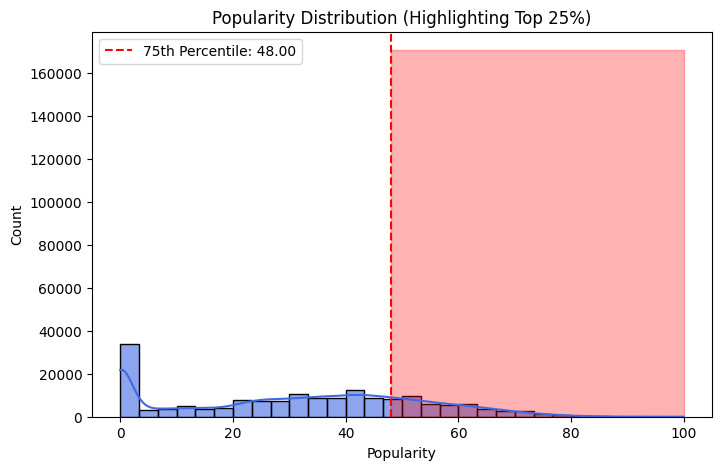

In [17]:
# Calculate the 75th percentile threshold
top_25_threshold = np.percentile(df["popularity"], 75)

# Plot the histogram
plt.figure(figsize=(8, 5))
sns.histplot(df["popularity"], bins=30, kde=True, color="royalblue", alpha=0.6)

# Highlight the top 25% region
plt.axvline(top_25_threshold, color="red", linestyle="dashed", label=f"75th Percentile: {top_25_threshold:.2f}")
plt.fill_betweenx(y=[0, df["popularity"].count()], x1=top_25_threshold, x2=df["popularity"].max(), color="red", alpha=0.3)

# Labels
plt.title("Popularity Distribution (Highlighting Top 25%)")
plt.xlabel("Popularity")
plt.ylabel("Count")
plt.legend()
plt.show()


# SPOTIFY ANALYSIS

Target audience: Record executives who are trying to find artists to sign.

## Questions:
- Are there any combinations of factors that tend to always (highly often) make certain tracks very popular?
- Are there any combinations of factors that tend to always (highly often) make certain tracks very unpopular?
- Find examples of tracks that have the factors required for popularity, but are actually unpopular (and vice-versa).

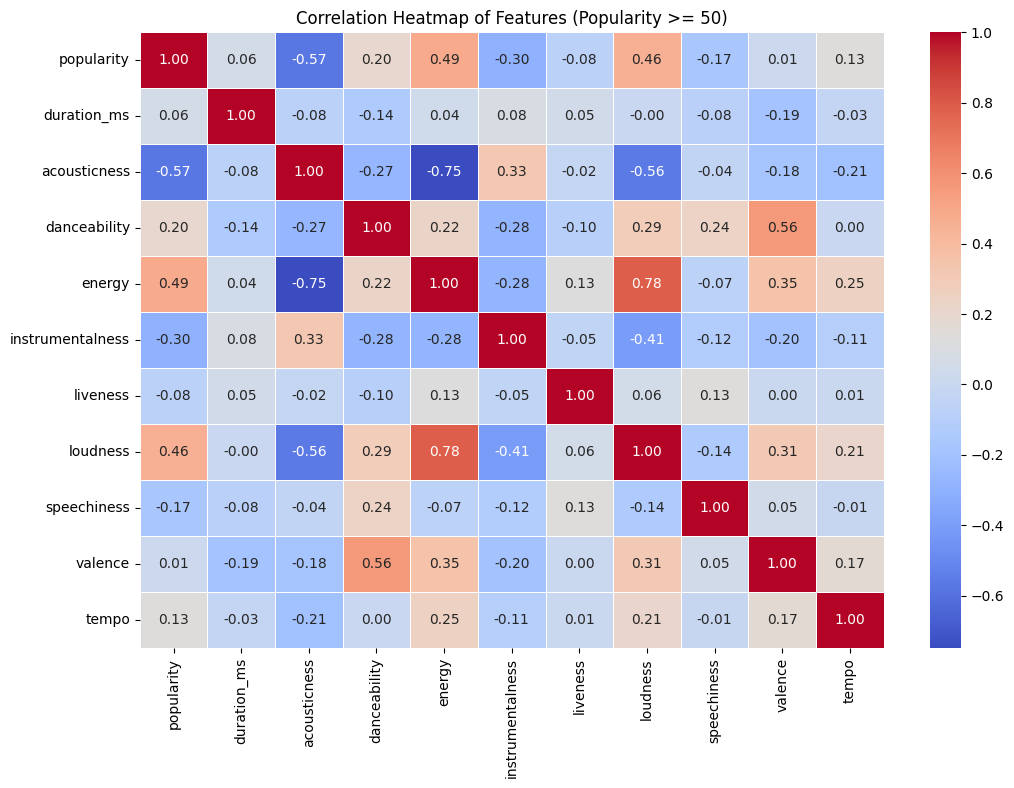

In [5]:
numerical_features = [
    "popularity", "duration_ms", "acousticness",
    "danceability", "energy", "instrumentalness", "liveness",
    "loudness", "speechiness", "valence", "tempo"
]

# Compute the correlation matrix
correlation_matrix = df[numerical_features].corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Features (Popularity >= 50)")
plt.show()

# SPOTIFY MODELS

Given some subset of songs which a person likes, build a model which recommends other similar songs. Be prepared to explain why you took the approach you did.

## Quantity and Quality Features

In [4]:
# Process artist names to ensure consistent formatting
df["artists"] = df["artists"].str.replace(r"[\[\]']", "", regex=True)  # Remove brackets and quotes

# Calculate num_songs (Total songs released per artist)
num_songs = df.groupby("artists")["id"].count().reset_index()
num_songs.columns = ["artists", "num_songs"]

# Calculate num_features (Total collaborations per song)
df["num_features"] = df["artists"].apply(lambda x: len(x.split(",")) - 1)

# Estimates Genre via Tempo, Enegry, Danceability, and Acousticness
def estimate_genre(row):
    bpm = row['tempo']
    energy = row['energy']
    danceability = row['danceability']
    acousticness = row['acousticness']
    speechiness = row['speechiness']
    instrumentalness = row['instrumentalness']
    year = row['year']
    loudness = row['loudness']  # Add loudness for modern genres

    # Pre-1950: Early genres only
    if year < 1950:
        if bpm < 80:
            return 'Folk' if acousticness > 0.6 else 'Ambient'
        else:
            return 'Jazz/Blues'

    # Pre-1970: No Hip-Hop or EDM/House
    if year < 1970:
        if bpm < 70:
            return 'Folk' if acousticness > 0.6 else 'Ambient'
        elif 70 <= bpm < 100:
            return 'Jazz/Blues' if acousticness > 0.4 else 'Pop'
        else:
            return 'Rock' if energy > 0.5 and instrumentalness > 0.1 else 'Pop'

    # Pre-1980: No EDM/House, Hip-Hop emerges
    if year < 1980:
        if bpm < 70:
            return 'Folk' if acousticness > 0.6 else 'Ambient'
        elif 70 <= bpm < 100:
            return 'Hip-Hop' if speechiness > 0.2 and danceability > 0.6 else 'Jazz/Blues'
        else:
            return 'Rock' if energy > 0.5 and instrumentalness > 0.1 else 'Pop'

    # 1980+: Full range
    if bpm < 70:  # Slow
        if acousticness > 0.6:
            return 'Folk'
        elif instrumentalness > 0.5:
            return 'Ambient'
        else:
            return 'Jazz/Blues'
    elif 70 <= bpm < 100:  # Moderate
        if speechiness > 0.2 and danceability > 0.65:
            return 'Hip-Hop'
        elif acousticness > 0.4:
            return 'Jazz/Blues'
        else:
            return 'Pop'
    elif 100 <= bpm < 120:  # Mid-high
        if danceability > 0.6 and loudness > -8:
            return 'Pop'
        elif energy > 0.6 and instrumentalness > 0.1:
            return 'Rock'
        else:
            return 'Jazz/Blues'
    elif 120 <= bpm < 160:  # Danceable
        if danceability > 0.65 and energy > 0.6 and loudness > -6:  # Relaxed instrumentalness
            return 'EDM/House'
        elif energy > 0.6 and danceability < 0.5:
            return 'Rock'
        else:
            return 'Pop'
    else:  # Fast (160+)
        if energy > 0.7 and danceability < 0.5:
            return 'Rock'
        elif danceability > 0.6 and loudness > -6:
            return 'EDM/House'
        else:
            return 'Ambient'

# Apply the function to estimate genre
df["estimated_genre"] = df.apply(estimate_genre, axis=1)

# Calculate genre diversity (Number of unique genres covered per artist)
genre_diversity = df.groupby("artists")["estimated_genre"].nunique().reset_index()
genre_diversity.columns = ["artists", "genre_diversity"]

# Merge calculated features into the dataset
df = df.merge(num_songs, on="artists", how="left")
df = df.merge(genre_diversity, on="artists", how="left")

In [ ]:
df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,mode,name,popularity,release_date,speechiness,tempo,num_features,estimated_genre,num_songs,genre_diversity
0,0.0594,1921,0.982,"Sergei Rachmaninoff, James Levine, Berliner Ph...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,...,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954,2,Jazz/Blues,2,1
1,0.9630,1921,0.732,Dennis Day,0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,...,1,Clancy Lowered the Boom,5,1921,0.4150,60.936,0,Folk,5,3
2,0.0394,1921,0.961,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,...,1,Gati Bali,5,1921,0.0339,110.339,0,Jazz/Blues,21,3
3,0.1650,1921,0.967,Frank Parker,0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,...,1,Danny Boy,3,1921,0.0354,100.109,0,Jazz/Blues,1,1
4,0.2530,1921,0.957,Phil Regan,0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,...,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665,0,Jazz/Blues,3,1


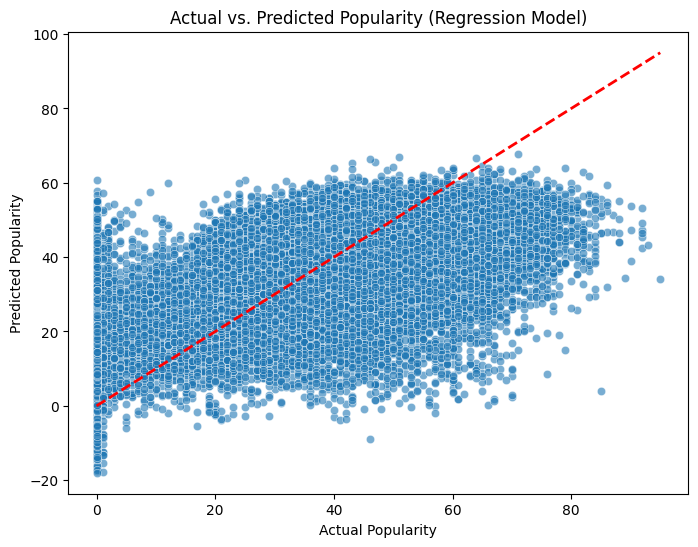

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Selecting features and target variable
features = ["num_songs", "num_features", "genre_diversity", "energy", "danceability", "speechiness", "valence", "instrumentalness", "acousticness", "loudness", "tempo"]
target = "popularity"

# Drop rows with missing values
df_main = df.dropna(subset=features + [target])

# Splitting data into training and test sets
X = df_main[features]
y = df_main[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training a Linear Regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Scatter plot of actual vs. predicted popularity
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r', linewidth=2)  # Diagonal line for reference
plt.xlabel("Actual Popularity")
plt.ylabel("Predicted Popularity")
plt.title("Actual vs. Predicted Popularity (Regression Model)")
plt.show()

In [ ]:
# Evaluating the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")


Mean Absolute Error: 12.904927845850219
R^2 Score: 0.46086432269395017


MAE = 12.9:  
- This means that, on average, the model’s predicted popularity differs from the actual popularity by about 12.90 points.
- Popularity scores typically range from 0 to 100, so an error of ~12.90 suggests moderate accuracy—the model is making some significant prediction mistakes.

R^2 = 0.46:
- An R² of 0.46 means that 46% of the variation in song popularity is explained by the model

Quantity-Based Model -> MAE: 16.991922135952823, R²: 0.12569709607379742
Quality-Based Model -> MAE: 13.152590205499848, R²: 0.44020927850761127


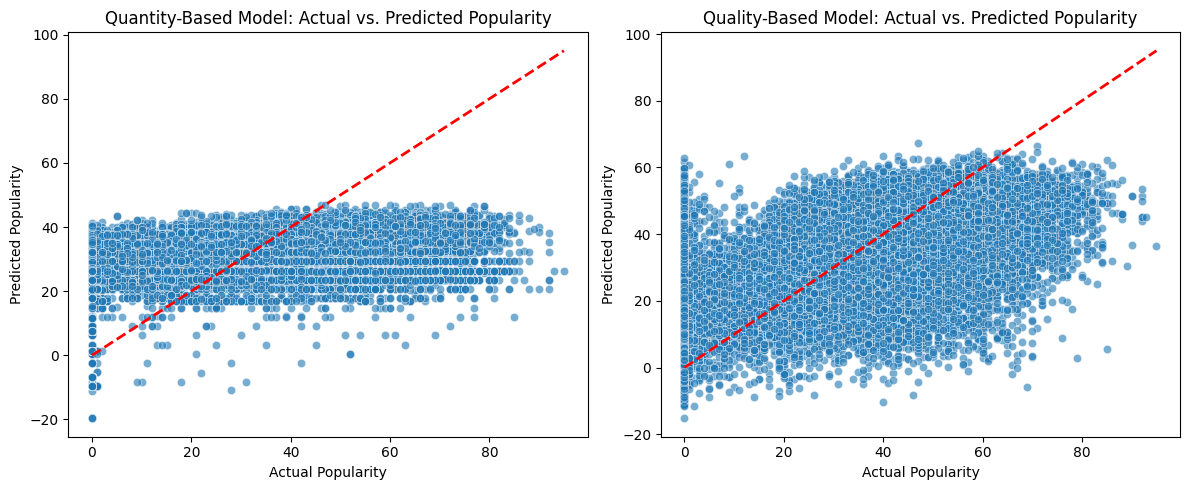

In [ ]:
# Define Quantity-based features and Quality-based features
quantity_features = ["num_songs", "num_features", "genre_diversity"]
quality_features = ["energy", "danceability", "speechiness", "valence", "instrumentalness", "acousticness", "loudness", "tempo"]

# Drop missing values for both models
df_quantity = df_main.dropna(subset=quantity_features + ["popularity"])
df_quality = df_main.dropna(subset=quality_features + ["popularity"])

# Split data for Quantity Model
X_quantity = df_quantity[quantity_features]
y_quantity = df_quantity["popularity"]
Xq_train, Xq_test, yq_train, yq_test = train_test_split(X_quantity, y_quantity, test_size=0.2, random_state=42)

# Split data for Quality Model
X_quality = df_quality[quality_features]
y_quality = df_quality["popularity"]
Xql_train, Xql_test, yql_train, yql_test = train_test_split(X_quality, y_quality, test_size=0.2, random_state=42)

# Standardize the features for both models
scaler_quantity = StandardScaler()
Xq_train_scaled = scaler_quantity.fit_transform(Xq_train)
Xq_test_scaled = scaler_quantity.transform(Xq_test)

scaler_quality = StandardScaler()
Xql_train_scaled = scaler_quality.fit_transform(Xql_train)
Xql_test_scaled = scaler_quality.transform(Xql_test)

# Train Linear Regression Model for Quantity Features
model_quantity = LinearRegression()
model_quantity.fit(Xq_train_scaled, yq_train)
yq_pred = model_quantity.predict(Xq_test_scaled)

# Train Linear Regression Model for Quality Features
model_quality = LinearRegression()
model_quality.fit(Xql_train_scaled, yql_train)
yql_pred = model_quality.predict(Xql_test_scaled)

# Evaluate both models
mae_quantity = mean_absolute_error(yq_test, yq_pred)
r2_quantity = r2_score(yq_test, yq_pred)

mae_quality = mean_absolute_error(yql_test, yql_pred)
r2_quality = r2_score(yql_test, yql_pred)

# Print evaluation metrics
print(f"Quantity-Based Model -> MAE: {mae_quantity}, R²: {r2_quantity}")
print(f"Quality-Based Model -> MAE: {mae_quality}, R²: {r2_quality}")

# Visualization of both models' predictions
plt.figure(figsize=(12, 5))

# Quantity Model Plot
plt.subplot(1, 2, 1)
sns.scatterplot(x=yq_test, y=yq_pred, alpha=0.6)
plt.plot([min(yq_test), max(yq_test)], [min(yq_test), max(yq_test)], '--r', linewidth=2)
plt.xlabel("Actual Popularity")
plt.ylabel("Predicted Popularity")
plt.title("Quantity-Based Model: Actual vs. Predicted Popularity")

# Quality Model Plot
plt.subplot(1, 2, 2)
sns.scatterplot(x=yql_test, y=yql_pred, alpha=0.6)
plt.plot([min(yql_test), max(yql_test)], [min(yql_test), max(yql_test)], '--r', linewidth=2)
plt.xlabel("Actual Popularity")
plt.ylabel("Predicted Popularity")
plt.title("Quality-Based Model: Actual vs. Predicted Popularity")

plt.tight_layout()
plt.show()

Takeaways:
- Music popularity is more influenced by quality attributes (like danceability, energy, and loudness) than sheer quantity (number of songs, collaborations, and genre diversity).
- Just releasing more songs or collaborating frequently doesn’t strongly predict success—what matters is the sound and feel of the music.


## Genre breakdown

<ipython-input-13-003dee92d53a>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_popularity_sorted["popularity"], y=genre_popularity_sorted["estimated_genre"], palette="viridis")


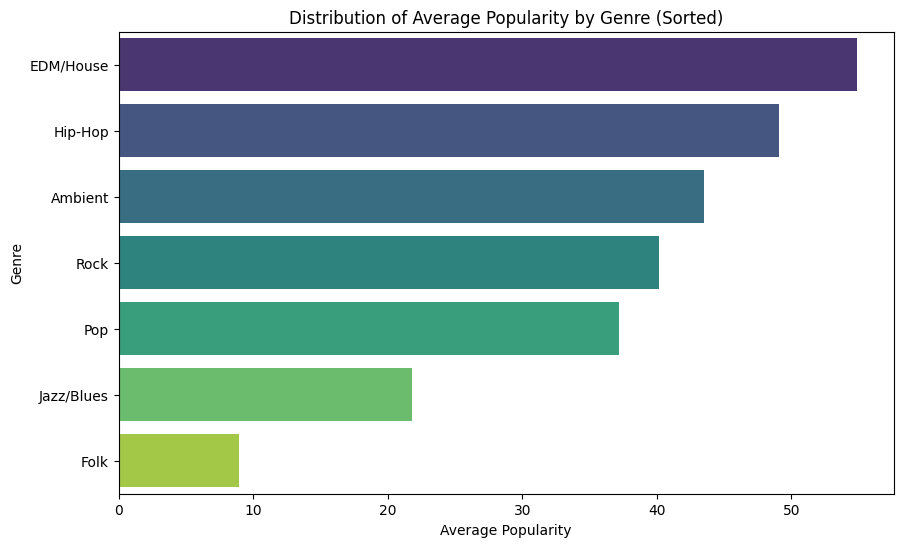

In [ ]:
# Calculate the average popularity per genre
genre_popularity = df_main.groupby("estimated_genre")["popularity"].mean().reset_index()

# Find the genre with the highest average popularity
top_genre = genre_popularity.loc[genre_popularity["popularity"].idxmax()]

# Sort the genres by average popularity in descending order
genre_popularity_sorted = genre_popularity.sort_values(by="popularity", ascending=False)

# Plot the sorted distribution of average popularity by genre
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_popularity_sorted["popularity"], y=genre_popularity_sorted["estimated_genre"], palette="viridis")
plt.xlabel("Average Popularity")
plt.ylabel("Genre")
plt.title("Distribution of Average Popularity by Genre (Sorted)")
plt.show()


Genre + Artists + Number of Songs Model -> MAE: 8.59973153030771, R²: 0.6710291022720922


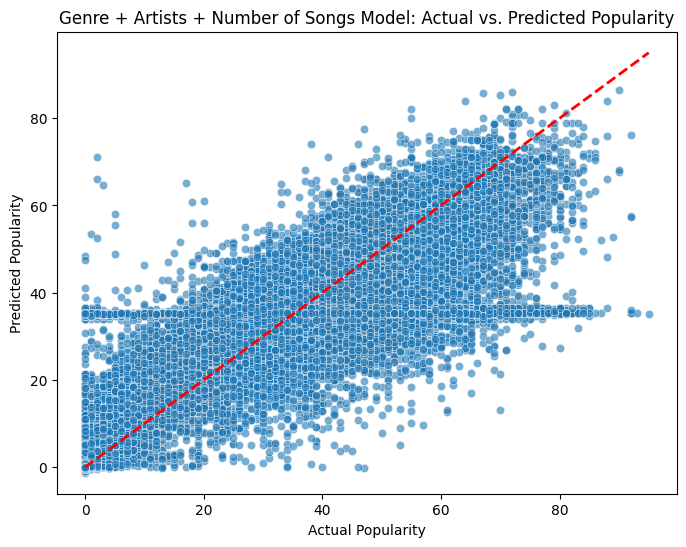

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Selecting features for the new model
categorical_features = ["estimated_genre", "artists"]
numerical_features = ["num_songs"]

# Drop missing values for these features
df_categorical = df_main.dropna(subset=categorical_features + numerical_features + ["popularity"])

# Splitting data
X_cat = df_categorical[categorical_features + numerical_features]
y_cat = df_categorical["popularity"]

Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_cat, y_cat, test_size=0.2, random_state=42)

# Preprocessing: One-hot encoding categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), numerical_features)
    ]
)

# Creating pipeline with regression model
model_categorical = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# Training the model
model_categorical.fit(Xc_train, yc_train)

# Predictions
yc_pred = model_categorical.predict(Xc_test)

# Evaluate the model
mae_categorical = mean_absolute_error(yc_test, yc_pred)
r2_categorical = r2_score(yc_test, yc_pred)

# Print evaluation metrics
print(f"Genre + Artists + Number of Songs Model -> MAE: {mae_categorical}, R²: {r2_categorical}")

# Scatter plot for predictions
plt.figure(figsize=(8, 6))
sns.scatterplot(x=yc_test, y=yc_pred, alpha=0.6)
plt.plot([min(yc_test), max(yc_test)], [min(yc_test), max(yc_test)], '--r', linewidth=2)
plt.xlabel("Actual Popularity")
plt.ylabel("Predicted Popularity")
plt.title("Genre + Artists + Number of Songs Model: Actual vs. Predicted Popularity")
plt.show()


Song Features Model (Acousticness, Tempo, etc.) -> MAE: 13.152590205499848, R²: 0.44020927850761127


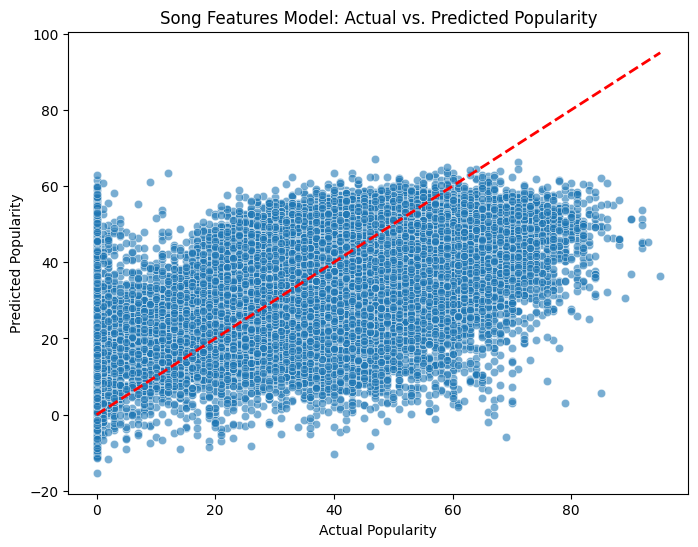

In [ ]:
# Define the alternative feature set (song characteristics only)
quality_features = ["energy", "danceability", "speechiness", "valence", "instrumentalness", "acousticness", "loudness", "tempo"]

# Drop missing values for the new model
df_quality = df_main.dropna(subset=quality_features + ["popularity"])

# Splitting data for the alternative model
X_quality = df_quality[quality_features]
y_quality = df_quality["popularity"]
Xq_train, Xq_test, yq_train, yq_test = train_test_split(X_quality, y_quality, test_size=0.2, random_state=42)

# Standardize the features
scaler_quality = StandardScaler()
Xq_train_scaled = scaler_quality.fit_transform(Xq_train)
Xq_test_scaled = scaler_quality.transform(Xq_test)

# Train Linear Regression Model for song characteristics
model_quality = LinearRegression()
model_quality.fit(Xq_train_scaled, yq_train)

# Predictions
yq_pred = model_quality.predict(Xq_test_scaled)

# Evaluate the model
mae_quality = mean_absolute_error(yq_test, yq_pred)
r2_quality = r2_score(yq_test, yq_pred)

# Print evaluation metrics
print(f"Song Features Model (Acousticness, Tempo, etc.) -> MAE: {mae_quality}, R²: {r2_quality}")

# Scatter plot for predictions
plt.figure(figsize=(8, 6))
sns.scatterplot(x=yq_test, y=yq_pred, alpha=0.6)
plt.plot([min(yq_test), max(yq_test)], [min(yq_test), max(yq_test)], '--r', linewidth=2)
plt.xlabel("Actual Popularity")
plt.ylabel("Predicted Popularity")
plt.title("Song Features Model: Actual vs. Predicted Popularity")
plt.show()


TAKEAWAYS
- The Genre + Artists + Num Songs model performs significantly better!
- Song features like acousticness, tempo, and speechiness may contribute to listener experience but don't determine popularity as strongly as an artist's reputation or genre.

Genre + Artists + Number of Songs + Year Model -> MAE: 6.841991144322186, R²: 0.8053337130273857


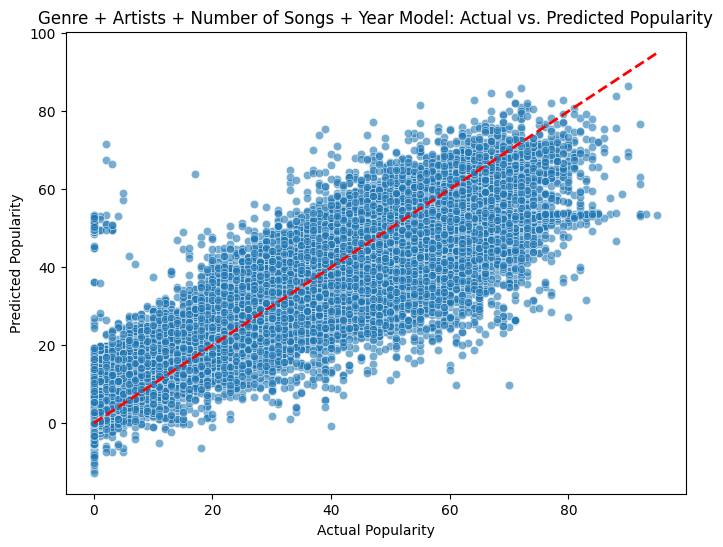

In [5]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Selecting features for the new model (Added 'year' to numerical features)
categorical_features = ["estimated_genre", "artists"]
numerical_features = ["num_songs", "year"]  # Added 'year'

# Drop missing values for these features
df_categorical = df.dropna(subset=categorical_features + numerical_features + ["popularity"])

# Splitting data
X_cat = df_categorical[categorical_features + numerical_features]
y_cat = df_categorical["popularity"]

Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_cat, y_cat, test_size=0.2, random_state=42)

# Preprocessing: One-hot encoding categorical variables, scaling numerical variables
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), numerical_features)  # Ensure 'year' is scaled
    ]
)

# Creating pipeline with regression model
model_categorical = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# Training the model
model_categorical.fit(Xc_train, yc_train)

# Predictions
yc_pred = model_categorical.predict(Xc_test)

# Evaluate the model
mae_categorical = mean_absolute_error(yc_test, yc_pred)
r2_categorical = r2_score(yc_test, yc_pred)

# Print evaluation metrics
print(f"Genre + Artists + Number of Songs + Year Model -> MAE: {mae_categorical}, R²: {r2_categorical}")

# Scatter plot for predictions
plt.figure(figsize=(8, 6))
sns.scatterplot(x=yc_test, y=yc_pred, alpha=0.6)
plt.plot([min(yc_test), max(yc_test)], [min(yc_test), max(yc_test)], '--r', linewidth=2)
plt.xlabel("Actual Popularity")
plt.ylabel("Predicted Popularity")
plt.title("Genre + Artists + Number of Songs + Year Model: Actual vs. Predicted Popularity")
plt.show()


In [7]:
from sklearn.metrics import mean_squared_error

# Compute RMSE manually
mse_categorical = mean_squared_error(yc_test, yc_pred)
rmse_categorical = np.sqrt(mse_categorical)  # Taking the square root

# Print evaluation metrics
print(f"Genre + Artists + Number of Songs + Year Model -> MAE: {mae_categorical}, RMSE: {rmse_categorical}, R²: {r2_categorical}")


Genre + Artists + Number of Songs + Year Model -> MAE: 6.841991144322186, RMSE: 9.651485884483424, R²: 0.8053337130273857
